In [1]:
from fastai.vision.widgets import *
from fastai.vision.all import *
import random

In [42]:
path = Path('images_norsk')
fns = get_image_files(path)
fns

(#3292) [Path('images_norsk/toppmeis/oppmeis-f.jpg'),Path('images_norsk/toppmeis/wryer.jpeg'),Path('images_norsk/toppmeis/standard_compressed_toppmeis_117778.jpg'),Path('images_norsk/toppmeis/y9_Image_11.jpg'),Path('images_norsk/toppmeis/240x180.jpg'),Path('images_norsk/toppmeis/Töyhtötiainen_orrella.jpg'),Path('images_norsk/toppmeis/toppmeis_stor.jpg'),Path('images_norsk/toppmeis/w2_Image_26.jpg'),Path('images_norsk/toppmeis/L5_Image_16.jpg'),Path('images_norsk/toppmeis/16_cool_toppmeis1.jpg')...]

In [43]:
seed = 41
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.25, seed=seed),
    get_y=parent_label,
)

## Summarizing notes

- No need to use larger image size than 224, since this will not be benefitial in the final app (where a crop of the full image will used, as identified by the object detection model (Yolo?))
- Due to fastai's builtin 1cycle (cyclical learning rate), 1. early stopping is discouraged (rather retrain your model if you overfit) and 2. "continuous training" does not work as expected, e.g by running first `learn.fit_one_cycle(6, lr_max=slice(1e-6, 1e-3))` and then "continue" the training with e.g. `learn.fit_one_cycle(2, lr_max=slice(1e-6, 1e-3))`
- 


**Results**:

It seems that an accuracy of 95% (on validation set) is acheiveable with this model. Pretty impressive, especially given how easy it was to get the model and training up and running with `fastai`. What could state of the art models push this to? Guesstimate could be 97% accuracy, perhaps. That would certainly be a relatively large improvement, but won't necessary make such a big difference to the app I have in mind.

## First approach

- item_tfms.min_scale=0.5 (should be done in `item_tfms` to reduce memory footprint on GPU)
- standard augmentation

In [44]:
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(),
)
dls = birds.dataloaders(path, bs=20)
learn = cnn_learner(dls, densenet161, metrics=error_rate)

In [45]:
# Train new head for 4 cycles
learn.fit_one_cycle(5, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.296743,0.752881,0.213852,01:26
1,0.764656,0.497322,0.149453,01:25
2,0.530087,0.342090,0.110571,01:26
3,0.295739,0.274513,0.076549,01:25
4,0.198829,0.246203,0.074119,01:26


In [46]:
# Unfreeze remaining layers
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.311311274956097e-06)

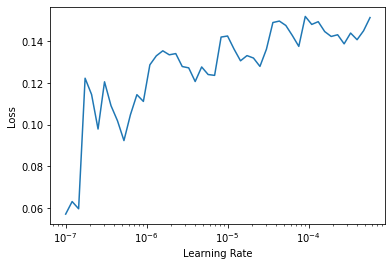

In [48]:
learn.lr_find() # What to make of this plot?

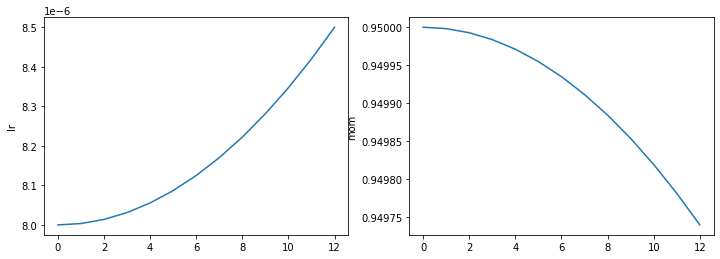

In [51]:
learn.recorder.plot_sched()

In [52]:
# Use discriminative learning rates: lower lr on deepest layers, higher lr on higher layers
learn.fit_one_cycle(12, lr_max=slice(1e-6, 2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.150457,0.226433,0.068044,01:39
1,0.144814,0.209973,0.066829,01:39
2,0.137527,0.211818,0.068044,01:40
3,0.119981,0.201681,0.063183,01:39
4,0.120337,0.199679,0.060753,01:40
5,0.087242,0.180996,0.055893,01:39
6,0.099549,0.182841,0.054678,01:40
7,0.058782,0.178923,0.053463,01:40
8,0.060606,0.183060,0.054678,01:39
9,0.071845,0.185534,0.059538,01:40


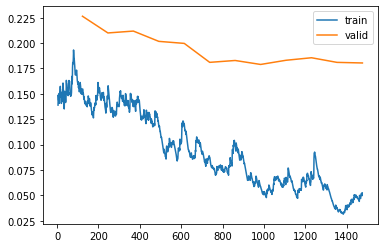

In [53]:
learn.recorder.plot_loss()

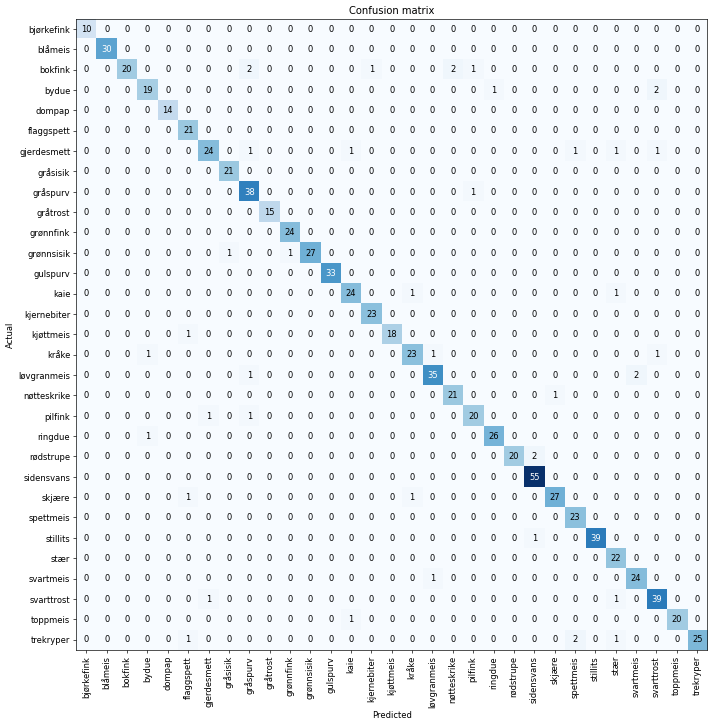

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

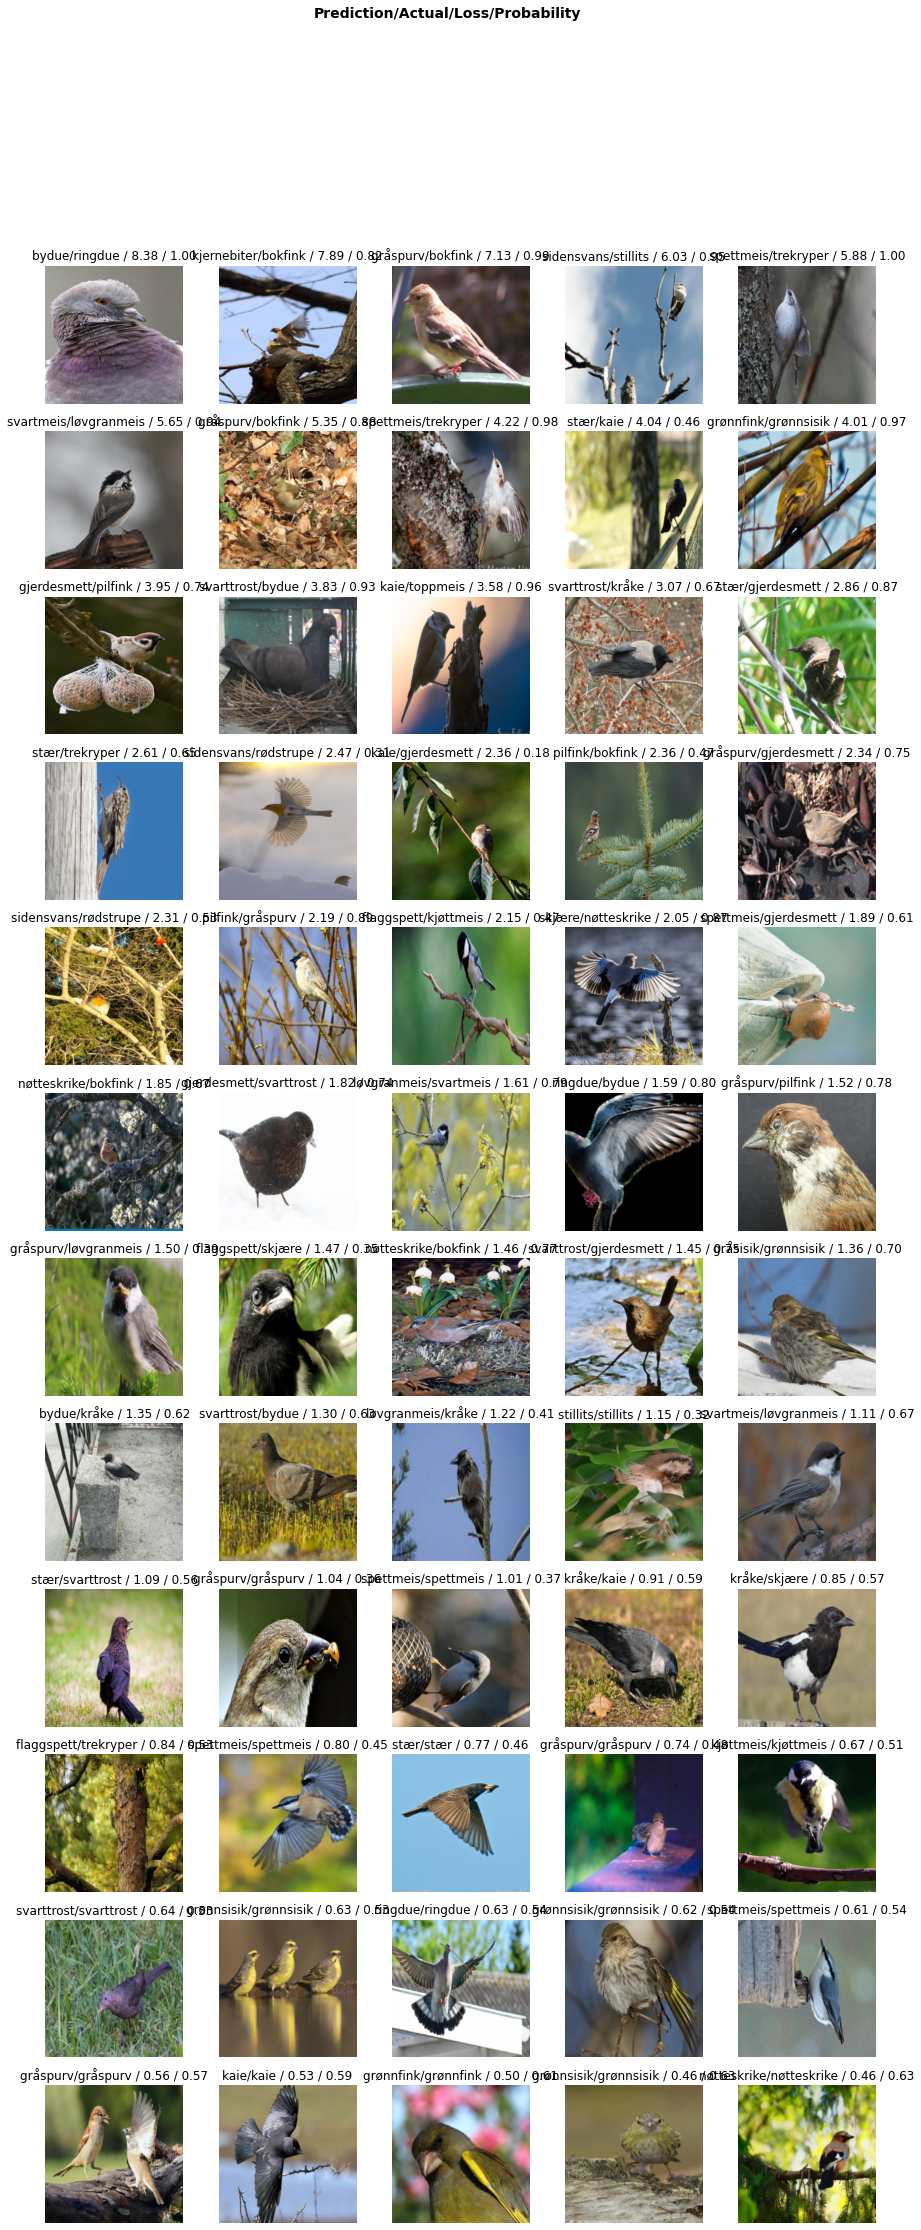

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(60, nrows=12)

## 16 bit floating precision (to train faster)

Tøft - at det er så enkelt! Men, ikke så mye tid å tjene på dette datasettet, av en grunn..

In [ ]:
# from fastai.callback.fp16 import *
# dls = birds.dataloaders(path, bs=32)
# learn = cnn_learner(dls, densenet161, metrics=error_rate).to_fp16()
# learn.fine_tune(6, freeze_epochs=3)